In [11]:
import os
import sys
import torch
import wandb
# import GPUtil
import torch.optim as optim
from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from ESTFormer import ESTFormer

sys.path.append('../../')
from utils.epoch_data_reader import EpochDataReader

In [12]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" # Force CUDA to use the GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use first GPU
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # Enable memory optimization settings for PyTorch
os.environ['WANDB_NOTEBOOK_NAME'] = 'model_training'

In [17]:
# # Check if CUDA is available
# try:
#     gpus = GPUtil.getGPUs()
#     if gpus:
#         print(f"GPUtil detected {len(gpus)} GPUs:")
#         for i, gpu in enumerate(gpus):
#             print(f"  GPU {i}: {gpu.name} (Memory: {gpu.memoryTotal}MB)")
        
#         # Set default GPU
#         os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in range(len(gpus))])
#         print(f"Set CUDA_VISIBLE_DEVICES={os.environ['CUDA_VISIBLE_DEVICES']}")
#     else:
#         print("GPUtil found no available GPUs")
# except Exception as e:
#     print(f"Error checking GPUs with GPUtil: {e}")

In [13]:
# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Print available GPU memory
if torch.cuda.is_available():
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Available GPU memory: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")

Using device: cuda
Total GPU memory: 99.98 GB
Available GPU memory: 0.58 GB


In [14]:
all_channels = ['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']

hr_channel_names = [
    'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 
    'Iz', 'Oz', 'POz', 'Pz', 'CPz', 
    'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2'
]

# Select 32 channels for the downsampled (low-resolution) set
# This selection preserves the overall spatial coverage while reducing density
lr_channel_names = [
    'PO7',
    'POz', 'Oz',
    'PO8',
]

# Model parameters
# hr_channel_names = all_channels # High-resolution setup (all channels)
# lr_channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] # Low-resolution setup (fewer channels)
builtin_montage = 'standard_1020'
alpha_t = 0.60
alpha_s = 0.75
r_mlp = 4 # amplification factor for MLP layers
dropout_rate = 0.5
L_s = 1  # Number of spatial layers
L_t = 1  # Number of temporal layers

# Training parameters
epochs = 100

# Optimizer parameters
lr = 5e-5
weight_decay = 0.5
beta_1 = 0.9
beta_2 = 0.95

# Dataset parameters
# split = "70/25/5"
# epoch_type = "around_evoked"
# before = 0.05
# after = 0.6
# random_state = 97

# Data Loader parameter
batch_size = 64

In [15]:
lo_res_dataset = EpochDataReader(
    channel_names=lr_channel_names
)

hi_res_dataset = EpochDataReader(
    channel_names=hr_channel_names
)

In [16]:
lo_res_loader = DataLoader(
    lo_res_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

hi_res_loader = DataLoader(
    hi_res_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

len(lo_res_loader), len(hi_res_loader)

(719, 719)

In [7]:
lo_res_dataset[0][0].shape, hi_res_dataset[0][0].shape

((4, 338), (29, 338))

In [17]:
# Get sample data to determine time_steps
sample_item = lo_res_dataset[0][0] if lo_res_dataset.epoch_type == 'around_evoked' else lo_res_dataset[0]
time_steps = sample_item.shape[1]
sfreq = lo_res_dataset.resample_freq

config = {
    "total_epochs_trained_on": epochs,
    "scale_factor": len(hr_channel_names) / len(lr_channel_names),
    "time_steps_in_seconds": time_steps / sfreq,
    "is_parieto_occipital_exclusive": True, #all(ch.startswith('P') or ch.startswith('O') or ch.startswith('PO') or ch.startswith('CP') for ch in lr_channel_names) and all(ch.startswith('P') or ch.startswith('O') or ch.startswith('PO') or ch.startswith('CP') for ch in hr_channel_names),
    "model_params": {
        "model": "ESTformer",
        "num_lr_channels": len(lr_channel_names),
        "num_hr_channels": len(hr_channel_names),
        "builtin_montage": builtin_montage,
        "alpha_s": alpha_s,
        "alpha_t": alpha_t,
        "r_mlp": r_mlp,
        "dropout_rate": dropout_rate,
        "L_s": L_s,
        "L_t": L_t,
    },
    "dataset_params": {
        "subject_session_id": lo_res_dataset.subject_session_id,
        "epoch_type": lo_res_dataset.epoch_type,
        "split": lo_res_dataset.split,
        "duration": str((lo_res_dataset.before + lo_res_dataset.after) * 1000) + 'ms' if lo_res_dataset.epoch_type == 'around_evoked' else lo_res_dataset.fixed_length_duration,
        "batch_size": batch_size,
        "random_state": lo_res_dataset.random_state
    },
    "optimizer_params": {
        "optimizer": "Adam",
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "betas": (beta_1, beta_2)
    }
}

In [18]:
model = ESTFormer(
    device=device, 
    lr_channel_names=lr_channel_names,
    hr_channel_names=hr_channel_names,
    builtin_montage=builtin_montage,
    time_steps=time_steps,
    alpha_t=alpha_t,
    alpha_s=alpha_s,
    r_mlp=r_mlp,
    dropout_rate=dropout_rate,
    L_s=L_s,
    L_t=L_t
)

summary(model)

Layer (type:depth-idx)                                                                Param #
ESTFormer                                                                             204
├─SigmaParameters: 1-1                                                                2
├─SIM: 1-2                                                                            --
│    └─Linear: 2-1                                                                    69,156
│    └─LayerNorm: 2-2                                                                 408
│    └─CAB: 2-3                                                                       --
│    │    └─ModuleList: 3-1                                                           502,532
│    └─MaskTokensInsert: 2-4                                                          --
│    │    └─MaskTokenExpander: 3-2                                                    204
│    └─Linear: 2-5                                                                    41,820
│

In [19]:
# Create optimizer with both model and sigma parameters
optimizer = optim.Adam(
    params=[{'params': model.parameters()}], 
    lr=lr,
    weight_decay=weight_decay,
    betas=(beta_1, beta_2)
)

with wandb.init(project="eeg-estformer", config=config) as run:
    history = model.fit(
        epochs=100,
        lo_res_loader=lo_res_loader,
        hi_res_loader=hi_res_loader,
        optimizer=optimizer,
        checkpoint_dir='cpoints',
        identifier='cross_PO_650ms_29_4',
        use_checkpoint=True
    )


No checkpoint found at cpoints/estformer_cross_PO_650ms_29_4_best.pt, starting from scratch


Epoch 1/100: 100%|██████████| 503/503 [00:14<00:00, 35.63it/s, loss=304.2400] 
                                                                                     

Epoch 1/100, train_loss: 317.7670val_loss: 280.2945sigma1: 1.0245, sigma2: 0.9749
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 2/100: 100%|██████████| 503/503 [00:14<00:00, 35.49it/s, loss=220.2395]
                                                                                     

Epoch 2/100, train_loss: 273.3134val_loss: 254.6649sigma1: 1.0489, sigma2: 0.9498
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 3/100: 100%|██████████| 503/503 [00:13<00:00, 36.98it/s, loss=202.8948]
                                                                                     

Epoch 3/100, train_loss: 249.9472val_loss: 234.6858sigma1: 1.0734, sigma2: 0.9247
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 4/100: 100%|██████████| 503/503 [00:13<00:00, 36.19it/s, loss=208.6299]
                                                                                     

Epoch 4/100, train_loss: 231.6115val_loss: 218.6862sigma1: 1.0977, sigma2: 0.8998
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 5/100: 100%|██████████| 503/503 [00:14<00:00, 34.58it/s, loss=384.7599]
                                                                                     

Epoch 5/100, train_loss: 216.5834val_loss: 204.9328sigma1: 1.1221, sigma2: 0.8749
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 6/100: 100%|██████████| 503/503 [00:13<00:00, 37.08it/s, loss=176.3053]
                                                                                     

Epoch 6/100, train_loss: 203.3083val_loss: 192.4124sigma1: 1.1465, sigma2: 0.8501
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 7/100: 100%|██████████| 503/503 [00:14<00:00, 35.07it/s, loss=144.5660]
                                                                                     

Epoch 7/100, train_loss: 191.1351val_loss: 180.8562sigma1: 1.1708, sigma2: 0.8259
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 8/100: 100%|██████████| 503/503 [00:13<00:00, 36.66it/s, loss=156.8310]
                                                                                     

Epoch 8/100, train_loss: 179.8860val_loss: 170.3008sigma1: 1.1950, sigma2: 0.8032
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 9/100: 100%|██████████| 503/503 [00:14<00:00, 34.64it/s, loss=172.4266]
                                                                                     

Epoch 9/100, train_loss: 169.5222val_loss: 160.3681sigma1: 1.2193, sigma2: 0.7867
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 10/100: 100%|██████████| 503/503 [00:13<00:00, 38.49it/s, loss=181.8228]
                                                                                     

Epoch 10/100, train_loss: 159.9301val_loss: 151.3405sigma1: 1.2436, sigma2: 0.7785
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 11/100: 100%|██████████| 503/503 [00:12<00:00, 39.19it/s, loss=139.4223]
                                                                                     

Epoch 11/100, train_loss: 151.0899val_loss: 143.0270sigma1: 1.2678, sigma2: 0.7734
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 12/100: 100%|██████████| 503/503 [00:13<00:00, 38.27it/s, loss=137.4565]
                                                                                     

Epoch 12/100, train_loss: 142.8230val_loss: 135.2874sigma1: 1.2921, sigma2: 0.7689
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 13/100: 100%|██████████| 503/503 [00:13<00:00, 37.17it/s, loss=125.1593]
                                                                                     

Epoch 13/100, train_loss: 135.2507val_loss: 128.0681sigma1: 1.3160, sigma2: 0.7635
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 14/100: 100%|██████████| 503/503 [00:13<00:00, 36.34it/s, loss=112.0539]
                                                                                     

Epoch 14/100, train_loss: 128.1970val_loss: 121.4492sigma1: 1.3401, sigma2: 0.7587
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 15/100: 100%|██████████| 503/503 [00:13<00:00, 37.11it/s, loss=121.9114]
                                                                                     

Epoch 15/100, train_loss: 121.7329val_loss: 115.2329sigma1: 1.3643, sigma2: 0.7537
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 16/100: 100%|██████████| 503/503 [00:13<00:00, 36.46it/s, loss=570.6448]
                                                                                     

Epoch 16/100, train_loss: 115.5281val_loss: 109.5615sigma1: 1.3887, sigma2: 0.7499
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 17/100: 100%|██████████| 503/503 [00:13<00:00, 35.95it/s, loss=96.4548] 
                                                                                     

Epoch 17/100, train_loss: 109.9614val_loss: 104.3007sigma1: 1.4124, sigma2: 0.7456
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 18/100: 100%|██████████| 503/503 [00:13<00:00, 36.89it/s, loss=111.4893]
                                                                                     

Epoch 18/100, train_loss: 104.7484val_loss: 99.3384sigma1: 1.4364, sigma2: 0.7410
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 19/100: 100%|██████████| 503/503 [00:14<00:00, 34.86it/s, loss=88.6118] 
                                                                                     

Epoch 19/100, train_loss: 99.9506val_loss: 94.8304sigma1: 1.4604, sigma2: 0.7367
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 20/100: 100%|██████████| 503/503 [00:13<00:00, 36.75it/s, loss=96.8985] 
                                                                                     

Epoch 20/100, train_loss: 95.4787val_loss: 90.6214sigma1: 1.4843, sigma2: 0.7317
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 21/100: 100%|██████████| 503/503 [00:14<00:00, 34.52it/s, loss=91.0843] 
                                                                                     

Epoch 21/100, train_loss: 91.3198val_loss: 86.6371sigma1: 1.5083, sigma2: 0.7281
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 22/100: 100%|██████████| 503/503 [00:13<00:00, 37.12it/s, loss=86.7594] 
                                                                                     

Epoch 22/100, train_loss: 87.5016val_loss: 83.0538sigma1: 1.5321, sigma2: 0.7244
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 23/100: 100%|██████████| 503/503 [00:13<00:00, 38.14it/s, loss=77.1273] 
                                                                                     

Epoch 23/100, train_loss: 83.9349val_loss: 79.7151sigma1: 1.5559, sigma2: 0.7205
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 24/100: 100%|██████████| 503/503 [00:13<00:00, 37.84it/s, loss=79.2603] 
                                                                                     

Epoch 24/100, train_loss: 80.6524val_loss: 76.6171sigma1: 1.5797, sigma2: 0.7168
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 25/100: 100%|██████████| 503/503 [00:13<00:00, 36.72it/s, loss=80.7562] 
                                                                                     

Epoch 25/100, train_loss: 77.5934val_loss: 73.7386sigma1: 1.6035, sigma2: 0.7137
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 26/100: 100%|██████████| 503/503 [00:13<00:00, 36.06it/s, loss=65.7850] 
                                                                                     

Epoch 26/100, train_loss: 74.7615val_loss: 71.1038sigma1: 1.6274, sigma2: 0.7106
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 27/100: 100%|██████████| 503/503 [00:12<00:00, 38.75it/s, loss=72.0824] 
                                                                                     

Epoch 27/100, train_loss: 72.1327val_loss: 68.6585sigma1: 1.6512, sigma2: 0.7082
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 28/100: 100%|██████████| 503/503 [00:13<00:00, 38.43it/s, loss=54.8439]
                                                                                     

Epoch 28/100, train_loss: 69.6950val_loss: 66.4316sigma1: 1.6752, sigma2: 0.7058
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 29/100: 100%|██████████| 503/503 [00:13<00:00, 37.80it/s, loss=68.2896]
                                                                                     

Epoch 29/100, train_loss: 67.4658val_loss: 64.3483sigma1: 1.6988, sigma2: 0.7038
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 30/100: 100%|██████████| 503/503 [00:14<00:00, 35.89it/s, loss=55.3739] 
                                                                                     

Epoch 30/100, train_loss: 65.4628val_loss: 62.4831sigma1: 1.7226, sigma2: 0.7019
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 31/100: 100%|██████████| 503/503 [00:13<00:00, 38.18it/s, loss=60.3823] 
                                                                                     

Epoch 31/100, train_loss: 63.5532val_loss: 60.7291sigma1: 1.7463, sigma2: 0.7003
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 32/100: 100%|██████████| 503/503 [00:13<00:00, 37.44it/s, loss=69.3772] 
                                                                                     

Epoch 32/100, train_loss: 61.8805val_loss: 59.2364sigma1: 1.7701, sigma2: 0.6997
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 33/100: 100%|██████████| 503/503 [00:11<00:00, 42.36it/s, loss=49.9974] 
                                                                                     

Epoch 33/100, train_loss: 60.2747val_loss: 57.7814sigma1: 1.7939, sigma2: 0.6990
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 34/100: 100%|██████████| 503/503 [00:13<00:00, 38.30it/s, loss=65.1100]
                                                                                     

Epoch 34/100, train_loss: 58.8591val_loss: 56.3799sigma1: 1.8177, sigma2: 0.6985
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 35/100: 100%|██████████| 503/503 [00:13<00:00, 38.31it/s, loss=53.6818]
                                                                                     

Epoch 35/100, train_loss: 57.5826val_loss: 55.2447sigma1: 1.8414, sigma2: 0.6993
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 36/100: 100%|██████████| 503/503 [00:14<00:00, 34.56it/s, loss=60.0667]
                                                                                     

Epoch 36/100, train_loss: 56.4336val_loss: 54.1930sigma1: 1.8653, sigma2: 0.7000
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 37/100: 100%|██████████| 503/503 [00:13<00:00, 37.99it/s, loss=43.5967]
                                                                                     

Epoch 37/100, train_loss: 55.4289val_loss: 53.2937sigma1: 1.8890, sigma2: 0.7011
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 38/100: 100%|██████████| 503/503 [00:16<00:00, 31.09it/s, loss=59.3675]
                                                                                     

Epoch 38/100, train_loss: 54.5359val_loss: 52.5604sigma1: 1.9128, sigma2: 0.7024
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 39/100: 100%|██████████| 503/503 [00:15<00:00, 32.04it/s, loss=51.5480] 
                                                                                     

Epoch 39/100, train_loss: 53.7905val_loss: 51.8116sigma1: 1.9366, sigma2: 0.7035
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 40/100: 100%|██████████| 503/503 [00:16<00:00, 29.98it/s, loss=42.6083] 
                                                                                     

Epoch 40/100, train_loss: 52.8525val_loss: 50.7244sigma1: 1.9605, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 41/100: 100%|██████████| 503/503 [00:15<00:00, 32.27it/s, loss=120.5758]
                                                                                     

Epoch 41/100, train_loss: 51.5372val_loss: 49.3863sigma1: 1.9843, sigma2: 0.7046
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 42/100: 100%|██████████| 503/503 [00:16<00:00, 29.88it/s, loss=39.5275]
                                                                                     

Epoch 42/100, train_loss: 50.2766val_loss: 48.2777sigma1: 2.0080, sigma2: 0.7047
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 43/100: 100%|██████████| 503/503 [00:14<00:00, 34.81it/s, loss=49.3790]
                                                                                     

Epoch 43/100, train_loss: 49.1418val_loss: 47.2229sigma1: 2.0316, sigma2: 0.7044
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 44/100: 100%|██████████| 503/503 [00:14<00:00, 35.79it/s, loss=56.1108] 
                                                                                     

Epoch 44/100, train_loss: 48.0551val_loss: 46.1566sigma1: 2.0555, sigma2: 0.7045
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 45/100: 100%|██████████| 503/503 [00:15<00:00, 31.48it/s, loss=50.9333]
                                                                                     

Epoch 45/100, train_loss: 47.0014val_loss: 45.1870sigma1: 2.0792, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 46/100: 100%|██████████| 503/503 [00:16<00:00, 29.76it/s, loss=36.5172]
                                                                                     

Epoch 46/100, train_loss: 46.0064val_loss: 44.1768sigma1: 2.1029, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 47/100: 100%|██████████| 503/503 [00:13<00:00, 36.38it/s, loss=42.1159] 
                                                                                     

Epoch 47/100, train_loss: 44.9975val_loss: 43.2449sigma1: 2.1267, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 48/100: 100%|██████████| 503/503 [00:15<00:00, 32.94it/s, loss=46.4510]
                                                                                     

Epoch 48/100, train_loss: 44.0720val_loss: 42.3837sigma1: 2.1504, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 49/100: 100%|██████████| 503/503 [00:15<00:00, 31.79it/s, loss=41.0212]
                                                                                     

Epoch 49/100, train_loss: 43.1439val_loss: 41.4835sigma1: 2.1740, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 50/100: 100%|██████████| 503/503 [00:13<00:00, 38.07it/s, loss=52.5302] 
                                                                                     

Epoch 50/100, train_loss: 42.2698val_loss: 40.6204sigma1: 2.1978, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 51/100: 100%|██████████| 503/503 [00:13<00:00, 36.76it/s, loss=38.1217]
                                                                                     

Epoch 51/100, train_loss: 41.3898val_loss: 39.8009sigma1: 2.2217, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 52/100: 100%|██████████| 503/503 [00:14<00:00, 35.28it/s, loss=28.8769] 
                                                                                     

Epoch 52/100, train_loss: 40.5733val_loss: 39.0304sigma1: 2.2455, sigma2: 0.7048
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 53/100: 100%|██████████| 503/503 [00:13<00:00, 36.86it/s, loss=42.0480]
                                                                                     

Epoch 53/100, train_loss: 39.7755val_loss: 38.2463sigma1: 2.2692, sigma2: 0.7047
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 54/100: 100%|██████████| 503/503 [00:14<00:00, 35.08it/s, loss=44.1699] 
                                                                                     

Epoch 54/100, train_loss: 38.9917val_loss: 37.4983sigma1: 2.2931, sigma2: 0.7046
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 55/100: 100%|██████████| 503/503 [00:13<00:00, 37.71it/s, loss=45.2302]
                                                                                     

Epoch 55/100, train_loss: 38.2367val_loss: 36.7595sigma1: 2.3169, sigma2: 0.7047
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 56/100: 100%|██████████| 503/503 [00:13<00:00, 38.16it/s, loss=47.4319]
                                                                                     

Epoch 56/100, train_loss: 37.4786val_loss: 36.0584sigma1: 2.3407, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 57/100: 100%|██████████| 503/503 [00:13<00:00, 36.84it/s, loss=59.1874]
                                                                                     

Epoch 57/100, train_loss: 36.7825val_loss: 35.4138sigma1: 2.3644, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 58/100: 100%|██████████| 503/503 [00:13<00:00, 37.93it/s, loss=28.5416]
                                                                                     

Epoch 58/100, train_loss: 36.0801val_loss: 34.7190sigma1: 2.3882, sigma2: 0.7050
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 59/100: 100%|██████████| 503/503 [00:13<00:00, 36.67it/s, loss=31.7868]
                                                                                     

Epoch 59/100, train_loss: 35.4228val_loss: 34.1072sigma1: 2.4118, sigma2: 0.7052
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 60/100: 100%|██████████| 503/503 [00:13<00:00, 36.03it/s, loss=172.5744]
                                                                                     

Epoch 60/100, train_loss: 34.7650val_loss: 33.4767sigma1: 2.4358, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 61/100: 100%|██████████| 503/503 [00:13<00:00, 37.67it/s, loss=33.2567]
                                                                                     

Epoch 61/100, train_loss: 34.1366val_loss: 32.8731sigma1: 2.4593, sigma2: 0.7049
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 62/100: 100%|██████████| 503/503 [00:13<00:00, 36.34it/s, loss=34.4309]
                                                                                     

Epoch 62/100, train_loss: 33.5240val_loss: 32.2622sigma1: 2.4831, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 63/100: 100%|██████████| 503/503 [00:13<00:00, 37.15it/s, loss=27.7921]
                                                                                     

Epoch 63/100, train_loss: 32.9276val_loss: 31.6989sigma1: 2.5069, sigma2: 0.7054
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 64/100: 100%|██████████| 503/503 [00:12<00:00, 40.50it/s, loss=33.7612]
                                                                                     

Epoch 64/100, train_loss: 32.3489val_loss: 31.1577sigma1: 2.5305, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 65/100: 100%|██████████| 503/503 [00:13<00:00, 37.89it/s, loss=34.0090] 
                                                                                     

Epoch 65/100, train_loss: 31.7844val_loss: 30.6313sigma1: 2.5543, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 66/100: 100%|██████████| 503/503 [00:13<00:00, 38.02it/s, loss=28.7714]
                                                                                     

Epoch 66/100, train_loss: 31.2307val_loss: 30.0955sigma1: 2.5781, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 67/100: 100%|██████████| 503/503 [00:14<00:00, 35.53it/s, loss=24.5335]
                                                                                     

Epoch 67/100, train_loss: 30.6927val_loss: 29.5925sigma1: 2.6018, sigma2: 0.7051
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 68/100: 100%|██████████| 503/503 [00:13<00:00, 37.94it/s, loss=27.7263]
                                                                                     

Epoch 68/100, train_loss: 30.1748val_loss: 29.0610sigma1: 2.6255, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 69/100: 100%|██████████| 503/503 [00:14<00:00, 35.87it/s, loss=25.7068] 
                                                                                     

Epoch 69/100, train_loss: 29.6652val_loss: 28.5748sigma1: 2.6493, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 70/100: 100%|██████████| 503/503 [00:14<00:00, 35.88it/s, loss=34.6868] 
                                                                                     

Epoch 70/100, train_loss: 29.1792val_loss: 28.1341sigma1: 2.6730, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 71/100: 100%|██████████| 503/503 [00:14<00:00, 35.60it/s, loss=20.5540]
                                                                                     

Epoch 71/100, train_loss: 28.7001val_loss: 27.6687sigma1: 2.6967, sigma2: 0.7060
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 72/100: 100%|██████████| 503/503 [00:13<00:00, 37.69it/s, loss=20.5973]
                                                                                     

Epoch 72/100, train_loss: 28.2436val_loss: 27.2240sigma1: 2.7203, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 73/100: 100%|██████████| 503/503 [00:13<00:00, 36.75it/s, loss=23.6079]
                                                                                     

Epoch 73/100, train_loss: 27.7824val_loss: 26.7789sigma1: 2.7440, sigma2: 0.7063
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 74/100: 100%|██████████| 503/503 [00:13<00:00, 36.73it/s, loss=29.9279]
                                                                                     

Epoch 74/100, train_loss: 27.3447val_loss: 26.3657sigma1: 2.7676, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 75/100: 100%|██████████| 503/503 [00:13<00:00, 36.10it/s, loss=24.8480]
                                                                                     

Epoch 75/100, train_loss: 26.9216val_loss: 25.9623sigma1: 2.7915, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 76/100: 100%|██████████| 503/503 [00:13<00:00, 36.52it/s, loss=20.1359]
                                                                                     

Epoch 76/100, train_loss: 26.4967val_loss: 25.5644sigma1: 2.8149, sigma2: 0.7063
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 77/100: 100%|██████████| 503/503 [00:13<00:00, 36.53it/s, loss=24.6108] 
                                                                                     

Epoch 77/100, train_loss: 26.0942val_loss: 25.1792sigma1: 2.8386, sigma2: 0.7060
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 78/100: 100%|██████████| 503/503 [00:14<00:00, 35.92it/s, loss=24.0132]
                                                                                     

Epoch 78/100, train_loss: 25.6952val_loss: 24.7888sigma1: 2.8623, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 79/100: 100%|██████████| 503/503 [00:13<00:00, 37.73it/s, loss=28.0159]
                                                                                     

Epoch 79/100, train_loss: 25.3165val_loss: 24.4186sigma1: 2.8859, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 80/100: 100%|██████████| 503/503 [00:13<00:00, 36.11it/s, loss=54.9887] 
                                                                                     

Epoch 80/100, train_loss: 24.9302val_loss: 24.0582sigma1: 2.9096, sigma2: 0.7062
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 81/100: 100%|██████████| 503/503 [00:13<00:00, 35.95it/s, loss=19.6782]
                                                                                     

Epoch 81/100, train_loss: 24.5635val_loss: 23.7464sigma1: 2.9331, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 82/100: 100%|██████████| 503/503 [00:13<00:00, 37.62it/s, loss=24.0572]
                                                                                     

Epoch 82/100, train_loss: 24.2071val_loss: 23.3654sigma1: 2.9567, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 83/100: 100%|██████████| 503/503 [00:13<00:00, 36.68it/s, loss=22.5307]
                                                                                     

Epoch 83/100, train_loss: 23.8607val_loss: 23.0212sigma1: 2.9803, sigma2: 0.7054
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 84/100: 100%|██████████| 503/503 [00:12<00:00, 39.23it/s, loss=18.0341]
                                                                                     

Epoch 84/100, train_loss: 23.5162val_loss: 22.6929sigma1: 3.0039, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 85/100: 100%|██████████| 503/503 [00:13<00:00, 36.81it/s, loss=20.1465]
                                                                                     

Epoch 85/100, train_loss: 23.1819val_loss: 22.3866sigma1: 3.0275, sigma2: 0.7058
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 86/100: 100%|██████████| 503/503 [00:14<00:00, 34.67it/s, loss=21.9455]
                                                                                     

Epoch 86/100, train_loss: 22.8528val_loss: 22.0697sigma1: 3.0510, sigma2: 0.7060
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 87/100: 100%|██████████| 503/503 [00:14<00:00, 34.62it/s, loss=19.1839]
                                                                                     

Epoch 87/100, train_loss: 22.5382val_loss: 21.7707sigma1: 3.0746, sigma2: 0.7053
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 88/100: 100%|██████████| 503/503 [00:13<00:00, 37.84it/s, loss=20.7502]
                                                                                     

Epoch 88/100, train_loss: 22.2269val_loss: 21.4553sigma1: 3.0982, sigma2: 0.7057
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 89/100: 100%|██████████| 503/503 [00:14<00:00, 34.22it/s, loss=25.8623]
                                                                                     

Epoch 89/100, train_loss: 21.9195val_loss: 21.1922sigma1: 3.1217, sigma2: 0.7059
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 90/100: 100%|██████████| 503/503 [00:13<00:00, 37.07it/s, loss=21.2842]
                                                                                     

Epoch 90/100, train_loss: 21.6385val_loss: 20.8904sigma1: 3.1450, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 91/100: 100%|██████████| 503/503 [00:14<00:00, 33.90it/s, loss=21.8852]
                                                                                     

Epoch 91/100, train_loss: 21.3434val_loss: 20.6141sigma1: 3.1685, sigma2: 0.7054
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 92/100: 100%|██████████| 503/503 [00:12<00:00, 38.89it/s, loss=17.8108]
                                                                                     

Epoch 92/100, train_loss: 21.0529val_loss: 20.3429sigma1: 3.1920, sigma2: 0.7063
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 93/100: 100%|██████████| 503/503 [00:14<00:00, 35.23it/s, loss=16.2088]
                                                                                     

Epoch 93/100, train_loss: 20.7752val_loss: 20.0747sigma1: 3.2156, sigma2: 0.7067
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 94/100: 100%|██████████| 503/503 [00:13<00:00, 37.24it/s, loss=23.9461]
                                                                                     

Epoch 94/100, train_loss: 20.5040val_loss: 19.8161sigma1: 3.2389, sigma2: 0.7061
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 95/100: 100%|██████████| 503/503 [00:13<00:00, 37.34it/s, loss=22.4622] 
                                                                                     

Epoch 95/100, train_loss: 20.2410val_loss: 19.5569sigma1: 3.2624, sigma2: 0.7063
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 96/100: 100%|██████████| 503/503 [00:13<00:00, 37.53it/s, loss=18.5244]
                                                                                     

Epoch 96/100, train_loss: 19.9837val_loss: 19.3290sigma1: 3.2860, sigma2: 0.7056
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 97/100: 100%|██████████| 503/503 [00:12<00:00, 38.72it/s, loss=15.5872]
                                                                                     

Epoch 97/100, train_loss: 19.7247val_loss: 19.0733sigma1: 3.3097, sigma2: 0.7064
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 98/100: 100%|██████████| 503/503 [00:13<00:00, 37.18it/s, loss=17.5223]
                                                                                     

Epoch 98/100, train_loss: 19.4769val_loss: 18.8482sigma1: 3.3330, sigma2: 0.7065
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 99/100: 100%|██████████| 503/503 [00:15<00:00, 32.54it/s, loss=15.5946]
                                                                                     

Epoch 99/100, train_loss: 19.2414val_loss: 18.6019sigma1: 3.3563, sigma2: 0.7055
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


Epoch 100/100: 100%|██████████| 503/503 [00:13<00:00, 36.98it/s, loss=18.1324]
                                                                                     

Epoch 100/100, train_loss: 19.0077val_loss: 18.3761sigma1: 3.3797, sigma2: 0.7063
Saved best model checkpoint to cpoints/estformer_cross_PO_650ms_29_4_best.pt


epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
sigma1,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
sigma2,█▇▅▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
sigma1,3.37974
sigma2,0.70632
train_loss,19.00767
val_loss,18.37606


In [20]:
lo_res_loader.dataset.set_split_type("all")
hi_res_loader.dataset.set_split_type("all")
len(lo_res_loader), len(hi_res_loader)

(719, 719)

In [21]:
from utils.metrics import (
    mae as compute_mean_absolute_error, 
    nmse as compute_normalized_mean_squared_error, 
    pcc as compute_pearson_correlation_coefficient,
    snr as compute_signal_to_noise_ratio,
    loss as reconstruction_loss,
)
import numpy as np

In [22]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_loader.dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_loader.dataset[i][0]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_loader.dataset[i][0]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.std(test_losses)
avg_test_mae = np.std(test_maes)
avg_test_nmse = np.std(test_nmse)
avg_test_snr = np.std(test_snr)
avg_test_pcc = np.std(test_pcc)

print({
    'loss': avg_test_loss, 
    'mae': avg_test_mae, 
    'nmse': avg_test_nmse, 
    'snr': avg_test_snr, 
    'pcc': avg_test_pcc
})  

{'loss': np.float64(47.086743824204206), 'mae': np.float64(0.27880570982173775), 'nmse': np.float64(0.00854258869661971), 'snr': np.float64(0.03753490652957217), 'pcc': np.float64(0.1518838427678436)}


In [23]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_loader.dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_loader.dataset[i][0]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_loader.dataset[i][0]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.mean(test_losses)
avg_test_mae = np.mean(test_maes)
avg_test_nmse = np.mean(test_nmse)
avg_test_snr = np.mean(test_snr)
avg_test_pcc = np.mean(test_pcc)

print({
    'loss': avg_test_loss, 
    'mae': avg_test_mae, 
    'nmse': avg_test_nmse, 
    'snr': avg_test_snr, 
    'pcc': avg_test_pcc
})  

{'loss': np.float64(18.72634536293204), 'mae': np.float64(0.6231985407908345), 'nmse': np.float64(0.9913483776497044), 'snr': np.float64(0.03789882155105099), 'pcc': np.float64(0.22231080678759066)}


In [84]:
lo_res_sub_dataset = EpochDataReader(
    channel_names=lr_channel_names,
    epoch_type = "fixed_length",
    fixed_length_duration=2,
    subject_session_id="subj08_session1"
)

hi_res_sub_dataset = EpochDataReader(
    channel_names=hr_channel_names,
    epoch_type = "fixed_length",
    fixed_length_duration=2,
    subject_session_id="subj08_session1"
)

Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj08_session1_eeg.fif...
    Range : 964 ... 1778950 =      1.883 ...  3474.512 secs
Ready.
Not setting metadata
1736 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1736 events and 1024 original time points ...
0 bad epochs dropped
Opening raw data file /workspace/eeg-image-decoding/code/utils/../../data/all-joined-1/eeg/preprocessed/ground-truth/subj08_session1_eeg.fif...
    Range : 964 ... 1778950 =      1.883 ...  3474.512 secs
Ready.
Not setting metadata
1736 matching events found
No baseline correction applied
0 projection items activated
Loading data for 1736 events and 1024 original time points ...
0 bad epochs dropped


In [85]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_sub_dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_sub_dataset[i]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_sub_dataset[i]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.std(test_losses)
avg_test_mae = np.std(test_maes)
avg_test_nmse = np.std(test_nmse)
avg_test_snr = np.std(test_snr)
avg_test_pcc = np.std(test_pcc)

print({
    'subject_loss': avg_test_loss, 
    'subject_mae': avg_test_mae, 
    'subject_nmse': avg_test_nmse, 
    'subject_snr': avg_test_snr, 
    'subject_pcc': avg_test_pcc
})  

{'subject_loss': np.float64(367.77311860678924), 'subject_mae': np.float64(0.36977608747501656), 'subject_nmse': np.float64(3.636364843830822e-05), 'subject_snr': np.float64(0.00015792352440409266), 'subject_pcc': np.float64(0.07547242010988042)}


In [59]:
test_losses = []
test_maes = []
test_nmse = []
test_snr = []
test_pcc = []
for i in range(len(lo_res_sub_dataset)):
    outputs = model.predict(torch.from_numpy(lo_res_sub_dataset[i]).float().to(model.device))
    hi_res = torch.from_numpy(hi_res_sub_dataset[i]).float().to(model.device)
    loss = reconstruction_loss(hi_res, outputs, model.sigmas.sigma1, model.sigmas.sigma2)
    mae = compute_mean_absolute_error(hi_res, outputs)
    nmse = compute_normalized_mean_squared_error(hi_res, outputs)
    snr = compute_signal_to_noise_ratio(hi_res, outputs)
    pcc = compute_pearson_correlation_coefficient(hi_res, outputs)

    test_losses.append(loss.item())
    test_maes.append(mae.item())
    test_nmse.append(nmse.item())
    test_snr.append(snr.item())
    test_pcc.append(pcc.item())

avg_test_loss = np.mean(test_losses)
avg_test_mae = np.mean(test_maes)
avg_test_nmse = np.mean(test_nmse)
avg_test_snr = np.mean(test_snr)
avg_test_pcc = np.mean(test_pcc)

print({
    'subject_loss': avg_test_loss, 
    'subject_mae': avg_test_mae, 
    'subject_nmse': avg_test_nmse, 
    'subject_snr': avg_test_snr, 
    'subject_pcc': avg_test_pcc
})  

{'subject_loss': np.float64(141.5141217879767), 'subject_mae': np.float64(0.5192700316514317), 'subject_nmse': np.float64(0.9999980168531573), 'subject_snr': np.float64(8.518937587249931e-06), 'subject_pcc': np.float64(0.0020403546021180306)}


Final sigma1 value: 3.380436658859253
Final sigma2 value: 0.7063338160514832


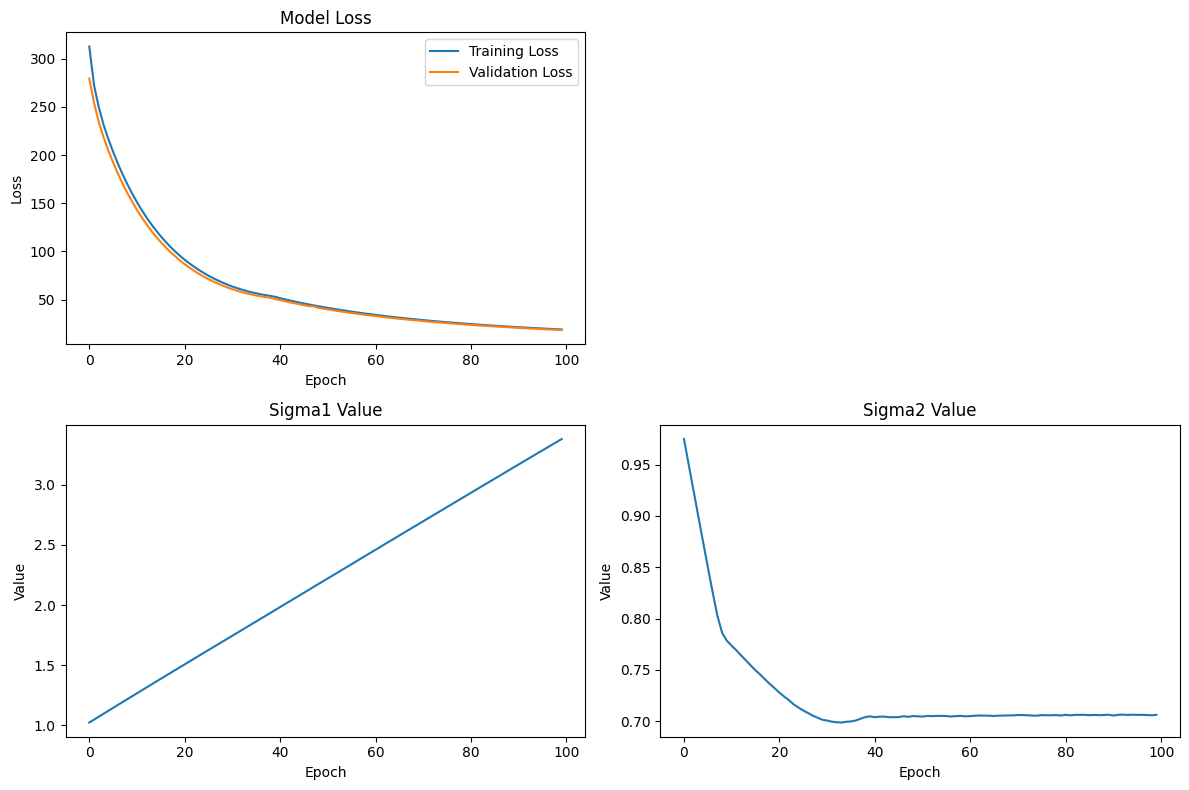

In [16]:
def monitor_sigma_values_and_loss(history):
    """
    Monitor the values of sigma1 and sigma2 during training.
    
    Args:
        history: Training history dictionary
    """
    # Get the values of sigma1 and sigma2
    sigma1_values = history['sigma1']
    sigma2_values = history['sigma2']
    
    print(f"Final sigma1 value: {sigma1_values[-1]}")
    print(f"Final sigma2 value: {sigma2_values[-1]}")
    
    # Plot the loss history
    plt.figure(figsize=(12, 8))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # # Plot MAE
    # plt.subplot(2, 2, 2)
    # plt.plot(history['train_mae'], label='Training MAE')
    # plt.plot(history['val_mae'], label='Validation MAE')
    # plt.title('Model MAE')
    # plt.xlabel('Epoch')
    # plt.ylabel('MAE')
    # plt.legend()

    # # Plot NMSE
    # plt.subplot(2, 2, 3)
    # plt.plot(history['train_nmse'], label='Training NMSE')
    # plt.plot(history['val_nmse'], label='Validation NMSE')
    # plt.title('Model NMSE')
    # plt.xlabel('Epoch')
    # plt.ylabel('NMSE')
    # plt.legend()

    # # Plot SNR
    # plt.subplot(2, 2, 4)
    # plt.plot(history['train_snr'], label='Training SNR')
    # plt.plot(history['val_snr'], label='Validation SNR')
    # plt.title('Model SNR')
    # plt.xlabel('Epoch')
    # plt.ylabel('SNR')
    # plt.legend()
    
    # # Plot PCC
    # plt.subplot(2, 2, 5)
    # plt.plot(history['train_pcc'], label='Training PCC')
    # plt.plot(history['val_pcc'], label='Validation PCC')
    # plt.title('Model PCC')
    # plt.xlabel('Epoch')
    # plt.ylabel('PCC')
    # plt.legend()
    
    # Plot sigma values
    plt.subplot(2, 2, 3)
    plt.plot(sigma1_values, label='Sigma1')
    plt.title('Sigma1 Value')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    plt.subplot(2, 2, 4)
    plt.plot(sigma2_values, label='Sigma2')
    plt.title('Sigma2 Value')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    
    plt.tight_layout()
    
    # Save figure to wandb
    if wandb.run is not None:
        wandb.log({"training_history": wandb.Image(plt)})
    
    plt.show()

monitor_sigma_values_and_loss(history)

In [13]:
# def visualize_results(model, val_dataset, device, subject_idx=0, channel_idx=0):
#     """
#     Visualize the results of the model on a validation sample.
    
#     Args:
#         model: Trained ESTformer model
#         val_dataset: Validation dataset
#         device: Device to run inference on
#         subject_idx: Index of the subject to visualize
#         channel_idx: Index of the channel to visualize
#     """
#     # Set model to eval mode
#     model.eval()
    
#     # Get a validation sample
#     sample = val_dataset[subject_idx]
    
#     # Convert to tensors and add batch dimension
#     lo_res = torch.tensor(sample['lo_res'], dtype=torch.float32).unsqueeze(0).to(device)
#     hi_res = torch.tensor(sample['hi_res'], dtype=torch.float32)
    
#     # Get predictions
#     with torch.no_grad():
#         pred = model(lo_res).cpu().numpy()[0]
    
#     # Convert back to numpy for visualization
#     lo_res = lo_res.cpu().numpy()[0]
#     hi_res = hi_res.numpy()
    
#     # Plot the results
#     plt.figure(figsize=(12, 8))
    
#     # Plot low-res input
#     plt.subplot(3, 1, 1)
#     plt.plot(lo_res[channel_idx])
#     plt.title(f'Low-Res (Downsampled) Input (Channel {channel_idx})')
    
#     # Plot high-res ground truth
#     plt.subplot(3, 1, 2)
#     plt.plot(hi_res[channel_idx])
#     plt.title(f'High-Res (Ground Truth) (Channel {channel_idx})')
    
#     # Plot prediction
#     plt.subplot(3, 1, 3)
#     plt.plot(pred[channel_idx])
#     plt.title(f'Super-Res (Prediction) (Channel {channel_idx})')
    
#     plt.tight_layout()
    
#     # Save figure to wandb
#     if wandb.run is not None:
#         wandb.log({"prediction_visualization": wandb.Image(plt)})
    
#     plt.show()

# visualize_results(model, val_loader.dataset, device)